# Recommender System with 4 different prediction algorithms

This project creates a recommendation system using famous Movie Lens Data Set. It contains 4 different methods for prediction protential user to movie ratings.
1. User based collaborative filltering using cosine similarity with RMSE as 2.9549033470934822
2. Item based collaborative filltering using cosine similarity with RMSE as 3.162305475602226
3. Simple SVD decomposition, RMSE as 2.122059408775827 - not bad!
4. Stochastic Gradient Descend, RMSE as 0.9386115723473495 - best option!. Under following conditions: K=20, iteration = 30, learning rate = 0.01, lambda to control over-fitting 0.1.

algorithm is based on here: https://www.youtube.com/watch?v=GGWBMg0i9d4&t=658s

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from math import sqrt
from scipy.sparse.linalg import svds

In [100]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)
movie_titles = pd.read_csv("Movie_Id_Titles")
movie = df.merge(movie_titles, on = 'item_id')
movie

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)
...,...,...,...,...,...
99998,840,1674,4,891211682,Mamma Roma (1962)
99999,655,1640,3,888474646,"Eighth Day, The (1996)"
100000,655,1637,3,888984255,Girls Town (1996)
100001,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."


In [5]:
n_user = movie.user_id.nunique()
n_item = movie.item_id.nunique()

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(movie, test_size=0.25)
train_matrix = np.zeros((n_user,n_item))
test_matrix = np.zeros((n_user,n_item))

In [7]:
#Create two user-item matrices, one for training and another for testing
for line in X_train.itertuples():
    train_matrix[line[1]-1, line[2]-1] = line[3]  

for line in X_test.itertuples():
    test_matrix[line[1]-1, line[2]-1] = line[3]

In [80]:
#Prediction using user based similairty 
user_sim = 1- pairwise_distances (train_matrix,metric='cosine')
np.fill_diagonal(user_sim,0)
mean = train_matrix.mean(axis=1)
diff = train_matrix - mean[:,np.newaxis]
user_pred = mean[:,np.newaxis] + np.dot(user_sim,diff)/user_sim.sum(axis=1)[:,np.newaxis] 

sqrt(mean_squared_error(user_pred[test_matrix.nonzero()],test_matrix[test_matrix.nonzero()]))

2.9549033470934822

In [97]:
#Prediction using item based similairty 
item_sim = 1- pairwise_distances (train_matrix.T,metric='cosine')
np.fill_diagonal(item_sim,0)
item_pred = np.dot(train_matrix,item_sim)/item_sim.sum(axis=1)
item_pred=np.nan_to_num(item_pred)
sqrt(mean_squared_error(item_pred[test_matrix.nonzero()],test_matrix[test_matrix.nonzero()]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


3.162305475602226

In [8]:
#Prediction P,Q using SVD (Singular Value Decompostion)
u,s,vt = svds(train_matrix, k=20)
P = u
Q = (np.diag(s)).dot(vt)

In [9]:
#check RMSE
pred = np.dot(P,Q)
sqrt(mean_squared_error(pred[test_matrix.nonzero()],test_matrix[test_matrix.nonzero()]))

2.717086411941729

In [53]:
# Prediction using Stochastic Gradient Descent
iteration =30
learning_rate = 0.01
lamda = 0.1
K = 20
user, item = train_matrix.nonzero()
train_error = []
test_error = []

In [54]:
#Randomized P,Q
P = np.random.rand(n_user,K)
Q = np.random.rand(K,n_item)

In [55]:
#check on current RMSE
pred = np.dot(P,Q)
sqrt(mean_squared_error(pred[test_matrix.nonzero()],test_matrix[test_matrix.nonzero()]))

2.122059408775827

In [56]:
train_error.append(sqrt(mean_squared_error(pred[train_matrix.nonzero()],train_matrix[train_matrix.nonzero()])))
test_error.append(sqrt(mean_squared_error(pred[test_matrix.nonzero()],test_matrix[test_matrix.nonzero()])))

In [57]:
#start to train 
for i in range(iteration):
    for u,i in zip(user,item):
        error = train_matrix[u,i] - np.dot(P[u,:],Q[:,i])
        P[u,:] += learning_rate * (error * Q[:,i] - lamda * P[u,:] )
        Q[:,i] += learning_rate * (error * P[u,:] - lamda * Q[:,i])
    pred = np.dot(P,Q)
    train_error.append(sqrt(mean_squared_error(pred[train_matrix.nonzero()],train_matrix[train_matrix.nonzero()])))
    test_error.append(sqrt(mean_squared_error(pred[test_matrix.nonzero()],test_matrix[test_matrix.nonzero()])))

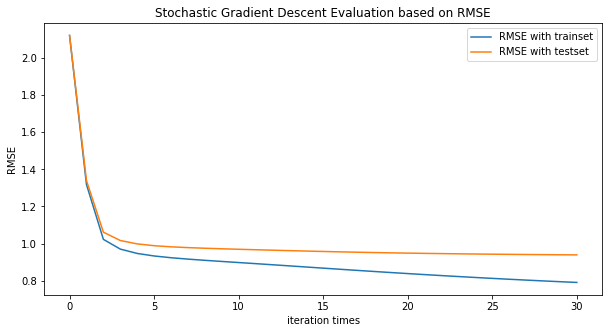

In [65]:
#check on RMSE with train set and test set
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(train_error,label = 'RMSE with trainset')
ax.plot(test_error,label = 'RMSE with testset')
ax.set_title('Stochastic Gradient Descent Evaluation based on RMSE')
ax.set_xlabel('iteration times')
ax.set_ylabel('RMSE')
ax.legend()